# Evaluation of the GBM GridSearchCV results

This file illustrates how to evaluate the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) results for sklearn's [GradientBoostingClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) obtained after first running `sklearn_gbm_tuning.py` in this directory to test various hyperparameter combinations and store the result.

## Imports & Settings

In [1]:
%matplotlib inline

import warnings
from pathlib import Path
import os
from datetime import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

from statsmodels.api import OLS, add_constant
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import roc_auc_score
import joblib

In [2]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
np.random.seed(42)
pd.options.display.float_format = '{:,.4f}'.format

In [3]:
with pd.HDFStore('data/tuning_sklearn_gbm.h5') as store:
    test_feature_data = store['holdout/features']
    test_features = test_feature_data.columns
    test_target = store['holdout/target']

## GBM GridsearchCV with sklearn

Need OneStepTimeSeriesSplit because stored GridSearchCV result expects it

In [4]:
class OneStepTimeSeriesSplit:
    pass

### Load Result

Need to first run `sklearn_gbm_tuning.py` to perform gridsearch and store result (not included due to file size).

In [6]:
gridsearch_result = joblib.load('results/sklearn_gbm_gridsearch.joblib')

The GridSearchCV object has several additional attributes after completion that we can access after loading the pickled result to learn which hyperparameter combination performed best and its average cross-validation AUC score, which results in a modest improvement over the default values. This is shown in the following code:

### Best Parameters & AUC Score

In [7]:
pd.Series(gridsearch_result.best_params_)

learning_rate             0.0100
max_depth                 9.0000
max_features              1.0000
min_impurity_decrease     0.0100
min_samples_split        50.0000
n_estimators            300.0000
subsample                 1.0000
dtype: float64

In [8]:
f'{gridsearch_result.best_score_:.4f}'

'0.5569'

### Evaluate best model

#### Test on hold-out set

In [9]:
best_model = gridsearch_result.best_estimator_

In [10]:
idx = pd.IndexSlice
test_dates = sorted(test_feature_data.index.get_level_values('date').unique())

In [11]:
auc = {}
for i, test_date in enumerate(test_dates):
    test_data = test_feature_data.loc[idx[:, test_date], :]
    preds = best_model.predict(test_data)
    auc[i] = roc_auc_score(y_true=test_target.loc[test_data.index], y_score=preds)

In [12]:
auc = pd.Series(auc)

In [13]:
auc.head()

0   0.5381
1   0.5163
2   0.5257
3   0.5061
4   0.5235
dtype: float64

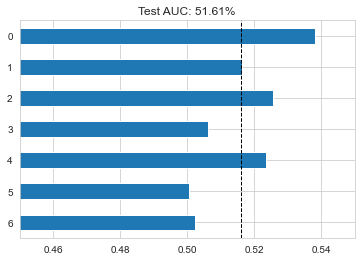

In [14]:
ax = auc.sort_index(ascending=False).plot.barh(xlim=(.45, .55), title=f'Test AUC: {auc.mean():.2%}')
ax.axvline(auc.mean(), ls='--', lw=1, c='k')
plt.savefig('figures/sklearn_gbm_test_auc', dpi=300);

#### Inspect global feature importance

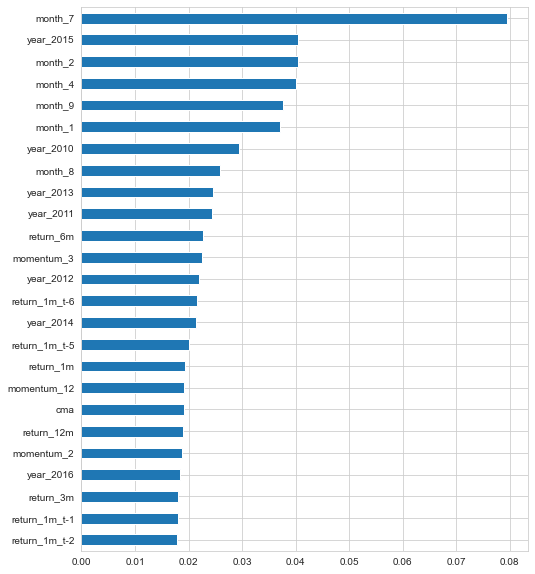

In [15]:
(pd.Series(best_model.feature_importances_, 
          index=test_features)
 .sort_values()
 .tail(25)
 .plot.barh(figsize=(8,10)));

### CV Train-Test Scores

In [16]:
results = pd.DataFrame(gridsearch_result.cv_results_).drop('params', axis=1)
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   mean_fit_time                576 non-null    float64
 1   std_fit_time                 576 non-null    float64
 2   mean_score_time              576 non-null    float64
 3   std_score_time               576 non-null    float64
 4   param_learning_rate          576 non-null    object 
 5   param_max_depth              576 non-null    object 
 6   param_max_features           576 non-null    object 
 7   param_min_impurity_decrease  576 non-null    object 
 8   param_min_samples_split      576 non-null    object 
 9   param_n_estimators           576 non-null    object 
 10  param_subsample              576 non-null    object 
 11  split0_test_score            576 non-null    float64
 12  split1_test_score            576 non-null    float64
 13  split2_test_score   

In [17]:
results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_max_features,param_min_impurity_decrease,param_min_samples_split,param_n_estimators,...,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,split10_train_score,split11_train_score,mean_train_score,std_train_score
0,27.0867,1.1143,0.0076,0.0007,0.0100,3,sqrt,0,10,100,...,0.6734,0.6724,0.6715,0.6711,0.6773,0.6722,0.6774,0.6814,0.6721,0.0049
1,31.4386,1.3369,0.0074,0.0006,0.0100,3,sqrt,0,10,100,...,0.6654,0.6744,0.6748,0.6706,0.6847,0.6762,0.6747,0.6786,0.6730,0.0059
2,81.3189,3.4796,0.0118,0.0009,0.0100,3,sqrt,0,10,300,...,0.6850,0.6867,0.6885,0.6864,0.6889,0.6895,0.6943,0.6958,0.6865,0.0052
3,93.7252,5.0023,0.0115,0.0006,0.0100,3,sqrt,0,10,300,...,0.6852,0.6855,0.6921,0.6896,0.6874,0.6857,0.6937,0.6964,0.6870,0.0050
4,26.9732,1.5380,0.0073,0.0004,0.0100,3,sqrt,0,50,100,...,0.6671,0.6807,0.6759,0.6752,0.6707,0.6767,0.6830,0.6789,0.6736,0.0061


### Get parameter values & mean test scores

In [18]:
test_scores = results.filter(like='param').join(results[['mean_test_score']])
test_scores = test_scores.rename(columns={c: '_'.join(c.split('_')[1:]) for c in test_scores.columns})
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   learning_rate          576 non-null    object 
 1   max_depth              576 non-null    object 
 2   max_features           576 non-null    object 
 3   min_impurity_decrease  576 non-null    object 
 4   min_samples_split      576 non-null    object 
 5   n_estimators           576 non-null    object 
 6   subsample              576 non-null    object 
 7   test_score             576 non-null    float64
dtypes: float64(1), object(7)
memory usage: 36.1+ KB


In [19]:
params = test_scores.columns[:-1].tolist()

In [20]:
test_scores = test_scores.set_index('test_score').stack().reset_index()
test_scores.columns= ['test_score', 'parameter', 'value']
test_scores.head()

,test_score,parameter,value
0,0.5151,learning_rate,0.0100
1,0.5151,max_depth,3
2,0.5151,max_features,sqrt
3,0.5151,min_impurity_decrease,0
4,0.5151,min_samples_split,10


In [21]:
test_scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4032 entries, 0 to 4031
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   test_score  4032 non-null   float64
 1   parameter   4032 non-null   object 
 2   value       4032 non-null   object 
dtypes: float64(1), object(2)
memory usage: 94.6+ KB


In [22]:
def get_test_scores(df):
    """Select parameter values and test scores"""
    data = df.filter(like='param').join(results[['mean_test_score']])
    return data.rename(columns={c: '_'.join(c.split('_')[1:]) for c in data.columns})

### Plot Test Scores vs Parameter Settings

The GridSearchCV result stores the average cross-validation scores so that we can analyze how different hyperparameter settings affect the outcome.

The six seaborn swarm plots below show the distribution of AUC test scores for all parameter values. In this case, the highest AUC  test scores required a low learning_rate and a large value for max_features. Some parameter settings, such as a low learning_rate, produce a wide range of outcomes that depend on the complementary settings of other parameters. Other parameters are compatible with high scores for all settings use in the experiment:

In [23]:
plot_data = get_test_scores(results).drop('min_impurity_decrease', axis=1)
plot_params = plot_data.columns[:-1].tolist()
plot_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   learning_rate      576 non-null    object 
 1   max_depth          576 non-null    object 
 2   max_features       576 non-null    object 
 3   min_samples_split  576 non-null    object 
 4   n_estimators       576 non-null    object 
 5   subsample          576 non-null    object 
 6   test_score         576 non-null    float64
dtypes: float64(1), object(6)
memory usage: 31.6+ KB


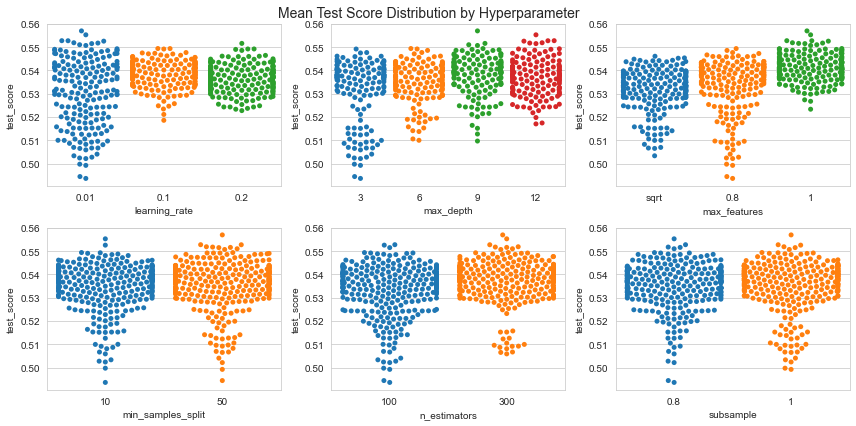

In [24]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(12, 6))
axes = axes.flatten()

for i, param in enumerate(plot_params):
    sns.swarmplot(x=param, y='test_score', data=plot_data, ax=axes[i])
    
fig.suptitle('Mean Test Score Distribution by Hyperparameter', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.94)
fig.savefig('figures/sklearn_cv_scores_by_param', dpi=300);

### Dummy-encode parameters

In [25]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   test_score                  576 non-null    float64
 1   learning_rate_0.01          576 non-null    uint8  
 2   learning_rate_0.1           576 non-null    uint8  
 3   learning_rate_0.2           576 non-null    uint8  
 4   max_depth_3                 576 non-null    uint8  
 5   max_depth_6                 576 non-null    uint8  
 6   max_depth_9                 576 non-null    uint8  
 7   max_depth_12                576 non-null    uint8  
 8   max_features_0.8            576 non-null    uint8  
 9   max_features_1              576 non-null    uint8  
 10  max_features_sqrt           576 non-null    uint8  
 11  min_impurity_decrease_0.0   576 non-null    uint8  
 12  min_impurity_decrease_0.01  576 non-null    uint8  
 13  min_samples_split_10        576 non

### Build Regression Tree

We will now explore how hyperparameter settings jointly affect the mean cross-validation score. To gain insight into how parameter settings interact, we can train a DecisionTreeRegressor with the mean test score as the outcome and the parameter settings, encoded as categorical variables in one-hot or dummy format. 

The tree structure highlights that using all features (max_features_1), a low learning_rate, and a max_depth over three led to the best results, as shown in the following diagram:

In [26]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 max_depth=4,
                                 min_samples_split=5,
                                 min_samples_leaf=10,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

In [27]:
gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=10, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=42, splitter='best')

In [28]:
reg_tree.feature_importances_

array([0.32877771, 0.        , 0.00539535, 0.26611295, 0.0109397 ,
       0.        , 0.00227883, 0.02879713, 0.23131014, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.12280906,
       0.        , 0.        , 0.00357913])

#### Visualize Tree

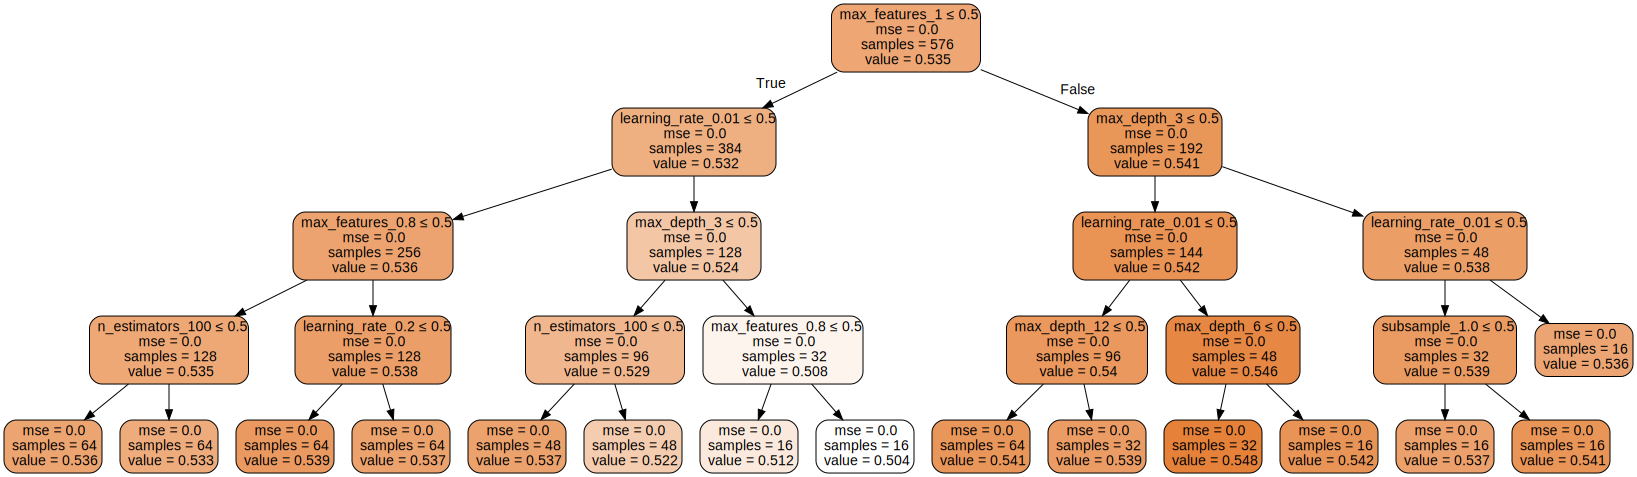

In [29]:
out_file = 'results/gbm_sklearn_tree.dot'
dot_data = export_graphviz(reg_tree,
                          out_file=out_file,
                          feature_names=gbm_features,
                          max_depth=4,
                          filled=True,
                          rounded=True,
                          special_characters=True)
if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

#### Compute Feature Importance

Overfit regression tree to learn detailed rules that classify all samples

In [30]:
reg_tree = DecisionTreeRegressor(criterion='mse',
                                 splitter='best',
                                 min_samples_split=2,
                                 min_samples_leaf=1,
                                 min_weight_fraction_leaf=0.0,
                                 max_features=None,
                                 random_state=42,
                                 max_leaf_nodes=None,
                                 min_impurity_decrease=0.0,
                                 min_impurity_split=None,
                                 presort=False)

gbm_features = data.drop('test_score', axis=1).columns
reg_tree.fit(X=data[gbm_features], y=data.test_score)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort=False,
                      random_state=42, splitter='best')

The bar chart below displays the influence of the hyperparameter settings in producing different outcomes, measured by their feature importance for a decision tree that is grown to its maximum depth. Naturally, the features that appear near the top of the tree also accumulate the highest importance scores.

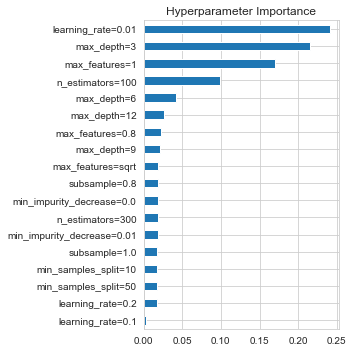

In [31]:
gbm_fi = (pd.Series(reg_tree.feature_importances_, 
                    index=gbm_features)
          .sort_values(ascending=False))
gbm_fi = gbm_fi[gbm_fi > 0]
idx = [p.split('_') for p in gbm_fi.index]
gbm_fi.index = ['_'.join(p[:-1]) + '=' + p[-1] for p in idx]
gbm_fi.sort_values().plot.barh(figsize=(5,5))
plt.title('Hyperparameter Importance')
plt.tight_layout()
plt.savefig('figures/sklearn_param_importance', dpi=300);

### Run linear regression

Alternatively, we can use a linear regression to gain insights into the statistical significance of the linear relationship between hyperparameters and test scores.

In [32]:
data = get_test_scores(results)
params = data.columns[:-1].tolist()
data = pd.get_dummies(data,columns=params, drop_first=True)

model = OLS(endog=data.test_score, exog=add_constant(data.drop('test_score', axis=1))).fit(cov_type='HC3')
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             test_score   R-squared:                       0.403
Model:                            OLS   Adj. R-squared:                  0.391
Method:                 Least Squares   F-statistic:                     26.95
Date:                Sat, 25 Apr 2020   Prob (F-statistic):           3.34e-45
Time:                        16:13:06   Log-Likelihood:                 1976.0
No. Observations:                 576   AIC:                            -3928.
Df Residuals:                     564   BIC:                            -3876.
Df Model:                          11                                         
Covariance Type:                  HC3                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               